# Socratic Models for Multimodal Reasoning
## Introduction
In this notebook, we use the Socratic models approach applied to multimodal reasoning tasks, i.e, chain-of-thought (CoT) reasoning & visual question-answering (VQA)

### Imports

In [1]:

# global
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from transformers import set_seed
import openai
from datasets import load_dataset

# local 
sys.path.insert(0, '../')
import scripts.image_captioning as ic
from scripts.utils import get_device
# extensions
%load_ext autoreload
%autoreload 2

/opt/conda/envs/dl2-sm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Set seed & device

In [2]:
set_seed(42)    # set seed for reproducibility
# set the device to use
device = get_device()
print(f'Using device: {device}')

Using device: cuda


#### Class instantiation

In [3]:
# instantiate managers
clip_manager = ic.ClipManager(device=device)
image_manager = ic.ImageManager()
vocab_manager = ic.VocabManager()
lm_manager = ic.LmManager(version='google/flan-t5-xxl', use_api=True, device=device)
openai.api_key = os.getenv('OPENAI_API_KEY')
prompt_generator = ic.LmPromptGenerator()

#### Create image & text embeddings

In [5]:
# compute place & objects features
place_feats = clip_manager.get_text_emb([f'Photo of a {p}.' for p in vocab_manager.place_list])
obj_feats = clip_manager.get_text_emb([f'Photo of a {o}.' for o in vocab_manager.object_list])

## Chain-of-thought reasoning
### Data
We use the [ScienceQA](https://scienceqa.github.io/) dataset.

In [6]:
# load scienceQA dataset
scienceQA_dataset = load_dataset('derek-thomas/ScienceQA', split='validation')
# filter out samples with no image
scienceQA_dataset = [sample for sample in scienceQA_dataset if sample['image'] is not None]

Found cached dataset parquet (/home/neil/.cache/huggingface/datasets/derek-thomas___parquet/derek-thomas--ScienceQA-ca4903a3b5795914/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


#### Visualize dataset samples

sample 0:


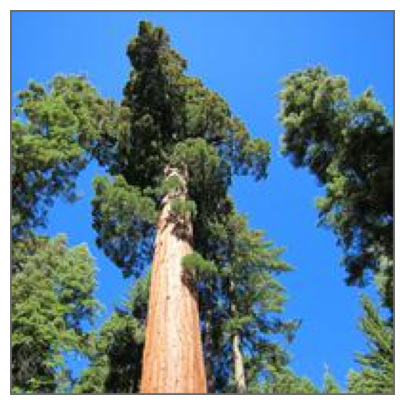

question: Is Sequoia sempervirens made up of one cell?
choices: ['no', 'yes']
hint: This organism is Sequoia sempervirens. It is a member of the plant kingdom.
Sequoia sempervirens is commonly called a coast redwood. The tallest known tree in the world is a coast redwood tree. It is 379 feet tall and over 700 years old!
answer: 0
solution: Sequoia sempervirens is a plant. Plants are made up of many cells.
--------------------------------------------------
sample 1:


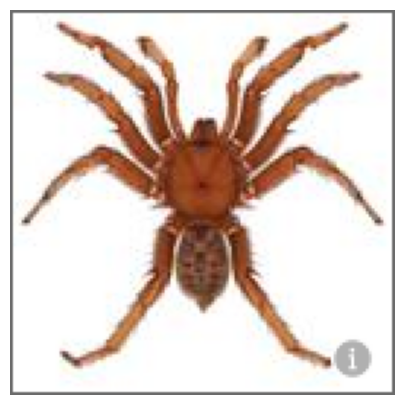

question: What is this trapdoor spider's scientific name?
choices: ['Aptostichus serrano', 'Aptostichus barackobamai']
hint: This species of trapdoor spider was named after President Barack Obama. The species was first discovered in Northern California in 2012.
answer: 1
solution: This organism's scientific name refers to President Barack Obama.
The word barackobamai refers to President Barack Obama. So, this trapdoor spider's scientific name is Aptostichus barackobamai.
--------------------------------------------------
sample 2:


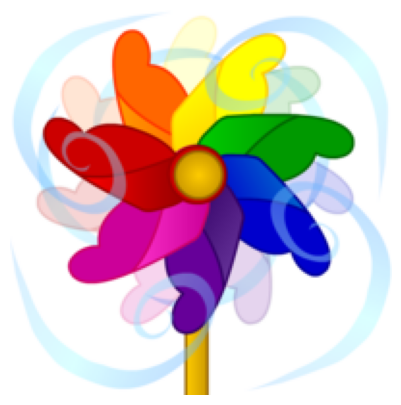

question: Is the wind turning a pinwheel a solid, a liquid, or a gas?
choices: ['a solid', 'a gas', 'a liquid']
hint: 
answer: 1
solution: Wind turning a pinwheel is air that is moving! Air is a gas. The air expands to fill the space around the pinwheel.
--------------------------------------------------
sample 3:


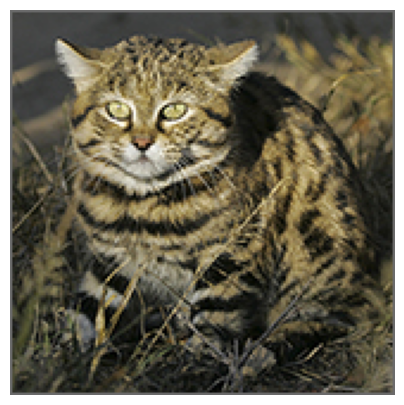

question: Select the organism in the same genus as the black-footed cat.
choices: ['Felis nigripes', 'Erinaceus europaeus', 'Phoebastria nigripes']
hint: This organism is a black-footed cat. Its scientific name is Felis nigripes.
answer: 0
solution: A black-footed cat's scientific name is Felis nigripes. The first word of its scientific name is Felis.
Phoebastria nigripes and Felis nigripes are not in the same genus.
These organisms are not in the same genus, but part of their scientific names is the same. Phoebastria nigripes and Felis nigripes have the same species name within their genus, nigripes. But the first words of their scientific names are different. Phoebastria nigripes is in the genus Phoebastria, and Felis nigripes is in the genus Felis.
This organism and the black-footed cat are in the same genus and the same species! Both organisms have the same scientific name, Felis nigripes.
Erinaceus europaeus is in the genus Erinaceus. The first word of its scientific name is Erina

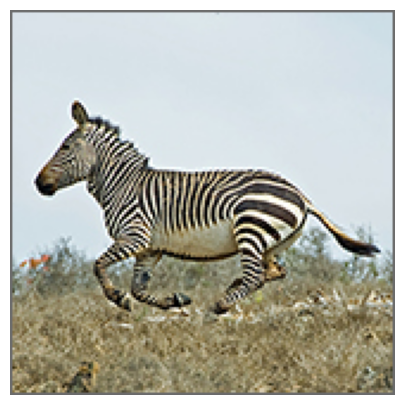

question: Select the organism in the same species as the mountain zebra.
choices: ['Equus zebra', 'Macropus giganteus', 'Macropus rufus']
hint: This organism is a mountain zebra. Its scientific name is Equus zebra.
answer: 0
solution: A mountain zebra's scientific name is Equus zebra.
Macropus rufus does not have the same scientific name as a mountain zebra. So, Equus zebra and Macropus rufus are not in the same species.
Macropus giganteus does not have the same scientific name as a mountain zebra. So, Equus zebra and Macropus giganteus are not in the same species.
Equus zebra has the same scientific name as a mountain zebra. So, these organisms are in the same species.
--------------------------------------------------
sample 5:


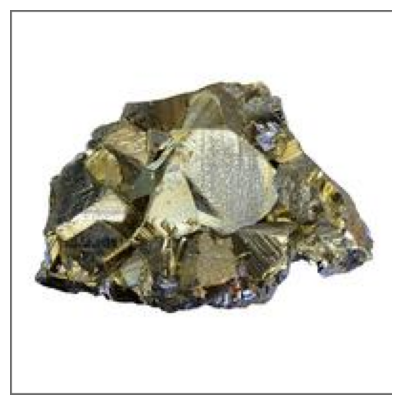

question: Is chalcopyrite a mineral or a rock?
choices: ['rock', 'mineral']
hint: Chalcopyrite has the following properties:
fixed crystal structure
found in nature
metallic luster
pure substance
not made by living things
solid
answer: 1
solution: Chalcopyrite has all the properties of a mineral. So, chalcopyrite is a mineral.
--------------------------------------------------
sample 6:


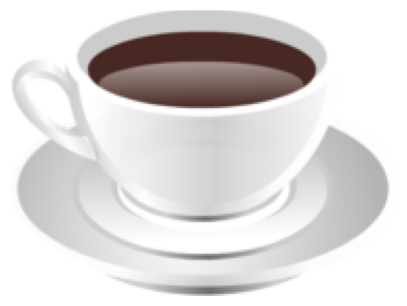

question: Is coffee a solid, a liquid, or a gas?
choices: ['a gas', 'a liquid', 'a solid']
hint: 
answer: 1
solution: Coffee is a liquid. A liquid takes the shape of any container it is in.
If you pour coffee into a different container, the coffee will take the shape of that container. But the coffee will still take up the same amount of space.
--------------------------------------------------
sample 7:


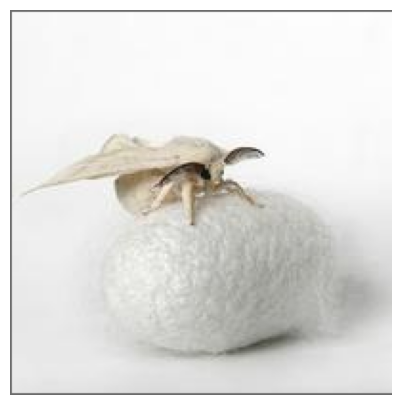

question: Is silk a mineral?
choices: ['yes', 'no']
hint: Silk has the following properties:
solid
made by a silkmoth caterpillar
no fixed crystal structure
found in nature
not a pure substance
answer: 1
solution: A silkmoth caterpillar makes a silk cocoon to protect itself during metamorphosis. In a silk factory, the silk from many silkmoth cocoons is spun into fabric. Silkmoth caterpillars that are used to make silk are often called silkworms.
--------------------------------------------------
sample 8:


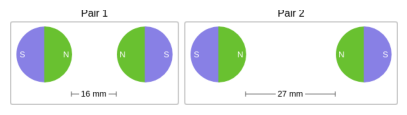

question: Think about the magnetic force between the magnets in each pair. Which of the following statements is true?
choices: ['The magnetic force is stronger in Pair 2.', 'The magnetic force is stronger in Pair 1.', 'The strength of the magnetic force is the same in both pairs.']
hint: The images below show two pairs of magnets. The magnets in different pairs do not affect each other. All the magnets shown are made of the same material.
answer: 1
solution: Distance affects the strength of the magnetic force. When magnets are closer together, the magnetic force between them is stronger.
The magnets in Pair 1 are closer together than the magnets in Pair 2. So, the magnetic force is stronger in Pair 1 than in Pair 2.
--------------------------------------------------
sample 9:


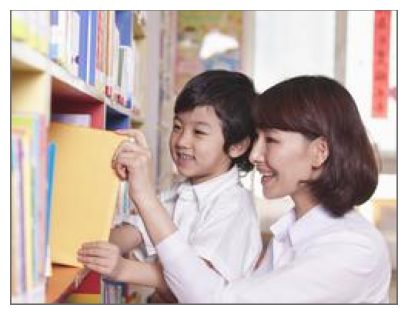

question: Which type of force from the woman's hand moves the book off of the shelf?
choices: ['push', 'pull']
hint: A woman takes a book off of a bookshelf. Her hand applies a force to the book.
answer: 1
solution: The woman's hand applies a force to the book.This force moves the book off the shelf. The direction of this force is toward her hand. This force is a pull.
--------------------------------------------------


In [43]:
# viz samples
# CoT samples: 68, 90, 122, 142, 155, 167, 177, 191, 202, 227, 234, 236, 254, 325, 340, 352
# VQA samples: 135, 140, 148, 155, 177, 202, 215, 223, 227, 234, 236, 237, 254, 257, 301, 307, 310, 311, 316, 319, 320, 324, 325, 327, 331, 334, 342, 348, 352
for i, sample in enumerate(scienceQA_dataset[350:360]):
    print(f'sample {i}:')
    plt.figure(figsize=(5, 5))
    plt.imshow(sample['image'])
    plt.axis('off')
    plt.show()
    # sample['image'].show()
    print('question:', sample['question'])
    print('choices:', sample['choices'])
    print('hint:', sample['hint'])
    # print('lecture:', sample['lecture'])
    print('answer:', sample['answer'])
    print('solution:', sample['solution'])
    print('-'*50)

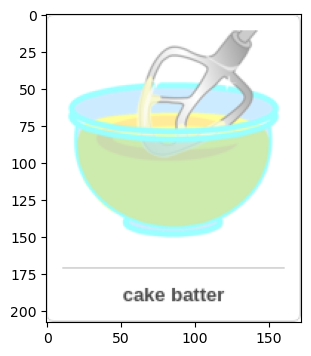

question: Which property matches this object?
choices: ['sweet', 'bouncy']
answer: 0
solution: Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.


In [41]:
# select & viz sample
sample_idx = 122
sample = scienceQA_dataset[sample_idx]
plt.figure(figsize=(4, 4))
plt.imshow(sample['image'])
plt.show()
print(f'question: {sample["question"]}\nchoices: {sample["choices"]}\nanswer: {sample["answer"]}\nsolution: {sample["solution"]}')

### Zero-shot CoT reasoning
Generate prompts using image info (CLIP) and questions, hints and choices from the dataset, along with a sentence to induce zero-shot CoT reasoning. Generate outputs (solution + rationale) from LM.

In [42]:
# compose prompt
prompt = prompt_generator.create_cot_prompt(sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

prompt: This image was taken in a kitchen. It contains a clabber, eggbeater, blender, whipping cream, batter, fondant, contrivance, gismo, widget, sifter.
Question: Which property matches this object?
Choices: ['sweet', 'bouncy']
Answer: Let's think step by step...



In [28]:
def get_response_gpt(prompt, model='gpt-3.5-turbo', temperature=1., max_tokens=100, **kwargs):
    '''Get response by prompting GPT-3'''
    response = openai.ChatCompletion.create(model=model, temperature=temperature, max_tokens=max_tokens, messages = [
        {"role": "user", "content": prompt}
    ], **kwargs)
    output = response['choices'][0]['message']['content']
    return output

# generate output
output = get_response_gpt(prompt)

print(f'output: {output}\ngt solution: {sample["solution"]}\ngt answer: {sample["answer"]}')

output: Based on the objects listed, none of them suggest a property of "bouncy." The closest property that could match would be "sweet," which could describe the batter or fondant. Therefore, the answer is "sweet."

gt solution: Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.
gt answer: 0


### Few-shot CoT reasoning
Generate prompts using image info (CLIP) and questions, hints and choices from the dataset, along with previous prompts & solutions (rational + choice) to induce few-shot CoT reasoning. Generate outputs from LM.

example sample:


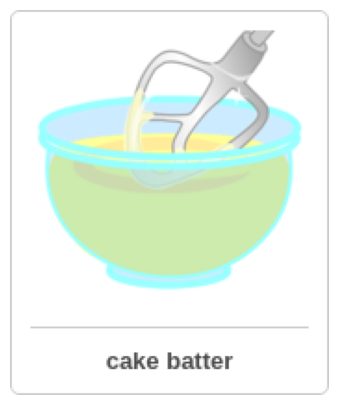

question: Which property matches this object?
choices: ['sweet', 'bouncy']
answer: 0
solution: Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.
target sample:


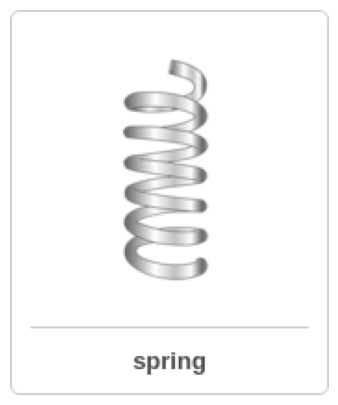

question: Which property matches this object?
choices: ['flexible', 'slippery']
answer: 0
solution: Look at the object.
Think about each property.
A flexible object can be folded or bent without breaking easily. The spring is flexible.
A slippery object is hard to hold onto or stand on. The spring is not slippery.


In [29]:
# select & viz example & target samples
# candidate pairs: single-prop: 122, 142 | multi-prop: 340, 142, 
# sample example
eg_sample_idx, target_sample_idx = 122, 142
eg_sample, target_sample = scienceQA_dataset[eg_sample_idx], scienceQA_dataset[target_sample_idx]
# show example sample
print('example sample:')
plt.figure(figsize=(5, 5))
plt.imshow(eg_sample['image'])
plt.axis('off')
plt.show()
print(f'question: {eg_sample["question"]}\nchoices: {eg_sample["choices"]}\nanswer: {eg_sample["answer"]}\nsolution: {eg_sample["solution"]}')

# show target sample
print('target sample:')
plt.figure(figsize=(4, 4))
plt.imshow(target_sample['image'])
plt.axis('off')
plt.show()
print(f'question: {target_sample["question"]}\nchoices: {target_sample["choices"]}\nanswer: {target_sample["answer"]}\nsolution: {target_sample["solution"]}')

In [38]:
# generate prompt
prompt = prompt_generator.create_cot_prompt(eg_sample, clip_manager, vocab_manager, place_feats, obj_feats) + f'{eg_sample["solution"]}. So the answer is {eg_sample["choices"][eg_sample["answer"]]}\n' + prompt_generator.create_cot_prompt(target_sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

prompt: This image was taken in a kitchen. It contains a clabber, eggbeater, blender, whipping cream, batter, fondant, contrivance, gismo, widget, sifter.
Question: Which property matches this object?
Choices: ['sweet', 'bouncy']
Answer: Let's think step by step...Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.. So the answer is sweet
This image was taken in a drugstore. It contains a spring, spring scale, coil, volute, sprig, set gun, whipping cream, elastic, spar, whisk.
Question: Which property matches this object?
Choices: ['flexible', 'slippery']
Answer: Let's think step by step...



In [33]:
# generate outputs from LM
output = get_response_gpt(prompt)
print(f'output: {output}\ngt solution: {sample["solution"]}\ngt answer: {target_sample["answer"]}')

output: Look at the object.
Think about each property.
Something that is flexible can bend without breaking. Springs and coils are flexible, so is the elastic.
Something that is slippery is smooth and difficult to hold or grip. None of these objects in the image have a slippery property. 
So the answer is flexible.

gt solution: Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.
gt answer: 0


### Zero-shot VQA
Zero-shot visual question-answering using VLM (CLIP + LM)

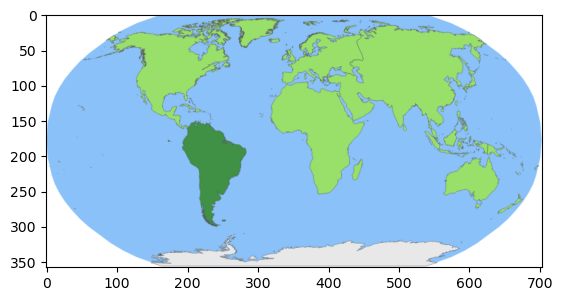

question: Which continent is highlighted?
choices: ['South America', 'Antarctica', 'North America']
answer: 0
solution: This continent is South America.


In [34]:
# get sample
# VQA samples: 134, 140, 148, 155, 177, 202, 215, 223, 227, 234, 236, 237, 254, 257
sample_idx = 134
sample = scienceQA_dataset[sample_idx]
# show sample
plt.figure(figsize=(4, 4))
plt.imshow(sample['image'])
plt.show()
print(f'question: {sample["question"]}\nchoices: {sample["choices"]}\nanswer: {sample["answer"]}\nsolution: {sample["solution"]}')

In [35]:
# compose prompt
prompt = prompt_generator.create_vqa_prompt(sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

# generate outputs from LM
output = get_response_gpt(prompt)
print(f'output: {output}\ngt answer: {sample["answer"]}')

prompt: This image was taken in a rainforest. It contains a Latin American, part, tennis ball, unit, geographical point, caranday, caranda palm, Copernicia australis, asclepiad, horseshoe. Using this information, answer the following question: Which continent is highlighted?
        Choices: ['South America', 'Antarctica', 'North America']
        Answer: 

output: South America

gt answer: 0
